# Document Retrieve - Chunking (Manual)

Chunking document manually using LangChain

- Data analysis (Token size)
- Chunking
    - text split by size
    - text split by format (MD)

## Doucment prep

Azure OpenAI documents (MD formatted)
- https://github.com/MicrosoftDocs/azure-docs/tree/main/articles/ai-services/openai

In [1]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def token_size(text):
    return len(encoding.encode(text))

In [2]:
import os
import pandas as pd
import re

In [3]:
def remove_between_markers(text, start_marker, end_marker):
    # Find the start and end positions of the markers
    start_pos = text.find(start_marker)
    end_pos = text.find(end_marker, start_pos + len(start_marker))
    
    # Remove the content between the markers
    if start_pos != -1 and end_pos != -1:
        return text[:start_pos] + text[end_pos + len(end_marker):]
    else:
        return text

In [4]:
with open(f'./docs/abuse-monitoring.md', "r") as f:
    input_text = f.read()
result_text = remove_between_markers(input_text, "---", "---\n\n")
result_text

'# Abuse Monitoring\n\nAzure OpenAI Service detects and mitigates instances of recurring content and/or behaviors that suggest use of the service in a manner that may violate the [Code of Conduct](/legal/cognitive-services/openai/code-of-conduct?context=/azure/ai-services/openai/context/context) or other applicable product terms. Details on how data is handled can be found on the [Data, Privacy and Security page](/legal/cognitive-services/openai/data-privacy?context=/azure/ai-services/openai/context/context).\n\n## Components of abuse monitoring\n\nThere are several components to abuse monitoring:\n\n- **Content Classification**: Classifier models detect harmful language and/or images in user prompts (inputs) and completions (outputs). The system looks for categories of harms as defined in the [Content Requirements](/legal/cognitive-services/openai/code-of-conduct?context=/azure/ai-services/openai/context/context), and assigns severity levels as described in more detail on the [Content

In [6]:
# Create an empty DataFrame with specific column names
df = pd.DataFrame(columns=['file_name', 'size', 'token_size', 'title', 'content'])

for md in os.listdir("./docs"):
    if not os.path.isdir(md):
        with open(f'./docs/{md}', "r") as f:
            text = f.read()

    pattern = r"title:\s*(.*)"
    matches = re.search(pattern, text)

    # get title from header
    title = ""
    if matches:
        title = matches.group(1)
        title = title.replace("'", "")
    else:
        title = md

    # clean header
    text = remove_between_markers(text, "---", "---\n\n")
    
    new_row = {'file_name': md, 'size': len(text), 'token_size': token_size(text), 'title':  title, 'content': text}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df

,file_name,size,token_size,title,content
0,gpt-v-python.md,7731,1731,Quickstart: Use GPT-4 Turbo with Vision on you...,Use this article to get started using the Azur...
1,chatgpt-javascript.md,4699,1181,Quickstart: Use Azure OpenAI Service with the ...,[Source code](https://github.com/Azure/azure-s...
2,use-your-data-rest.md,3775,894,use-your-data-rest.md,[!INCLUDE [Set up required variables](./use-yo...
3,switching-endpoints.md,4866,1217,How to switch between OpenAI and Azure OpenAI ...,# How to switch between OpenAI and Azure OpenA...
4,dall-e-dotnet.md,4745,1212,Quickstart: Use Azure OpenAI Service with the ...,Use this guide to get started generating image...
...,...,...,...,...,...
134,dall-e-go.md,4952,1371,Quickstart: Use the OpenAI Service image gener...,Use this guide to get started generating image...
135,reproducible-output.md,14823,3530,How to generate reproducible output with Azure...,# Learn how to use reproducible output (previe...
136,assistants-quickstart.md,618,139,Quickstart - Getting started with Azure OpenAI...,\n# Quickstart: Get started using Azure OpenAI...
137,use-blocklists.md,13872,3211,How to use blocklists with Azure OpenAI Service,# Use a blocklist in Azure OpenAI\n\nThe confi...


In [7]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra

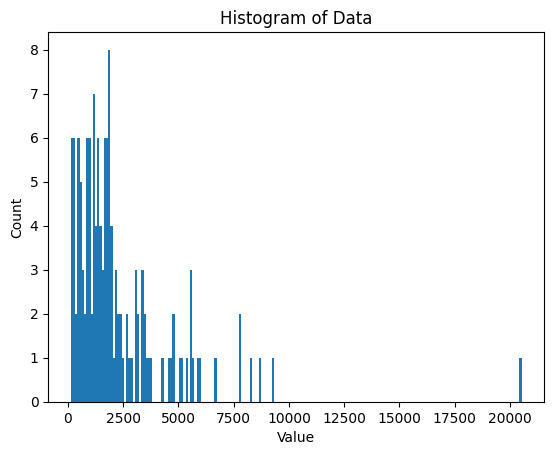

In [8]:
# chatgpt promt: "python code to plot a graph group by count of bin size from data"
data = df['token_size']

bin_size = 100

# Calculate the number of bins based on the bin size
num_bins = int(np.ceil((data.max() - data.min()) / bin_size))

# Create the histogram
plt.hist(data, bins=num_bins)

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Data')

# Show the plot
plt.show()

In [9]:
# file with token size > 8K
df[df['token_size'] > 8000]

,file_name,size,token_size,title,content
58,use-your-data.md,38966,8308,Using your data with Azure OpenAI Service,# Azure OpenAI On Your Data \n\nUse this artic...
68,content-filter.md,39998,9240,Azure OpenAI Service content filtering,# Content filtering\n\n> [!IMPORTANT]\n> The c...
82,reference.md,82819,20522,Azure OpenAI Service REST API reference,# Azure OpenAI Service REST API reference\n\nT...
98,assistant.md,32303,8656,How to create Assistants with Azure OpenAI Ser...,# Getting started with Azure OpenAI Assistants...


## Chunking Comparison

- https://github.com/Azure/azure-search-vector-samples/blob/main/demo-python/code/data-chunking/langchain-data-chunking-example.ipynb
- https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory#auto-detect-file-encodings-with-textloader

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_community.document_loaders import TextLoader

def get_encoding_name(model="gpt-3.5-turbo"):
    return tiktoken.encoding_for_model(model).name

In [11]:
# test chunking
row = df[df['file_name'] == 'use-your-data.md']
# use list function to show all text in the cell
md_content = list(row['content'])[0]
md_content

'# Azure OpenAI On Your Data \n\nUse this article to learn about Azure OpenAI On Your Data, which makes it easier for developers to connect, ingest and ground their enterprise data to create personalized copilots (preview) rapidly. It enhances user comprehension, expedites task completion, improves operational efficiency, and aids decision-making.\n\n## What is Azure OpenAI On Your Data\n\nAzure OpenAI On Your Data enables you to run advanced AI models such as GPT-35-Turbo and GPT-4 on your own enterprise data without needing to train or fine-tune models. You can chat on top of and analyze your data with greater accuracy. You can specify sources to support the responses based on the latest information available in your designated data sources. You can access Azure OpenAI On Your Data using a REST API, via the SDK or the web-based interface in the [Azure OpenAI Studio](https://oai.azure.com/). You can also create a web app that connects to your data to enable an enhanced chat solution o

### Text Splitter

In [13]:
# from_tiktoken_encoder enables use to split on tokens rather than characters
recursive_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
   encoding_name=get_encoding_name(),
   chunk_size=1000, 
   chunk_overlap=125
)

#recursive_text_splitter_chunks = recursive_text_splitter.split_documents(documents)
recursive_text_splitter_chunks = recursive_text_splitter.split_text(md_content)

In [14]:
len(recursive_text_splitter_chunks)

10

In [15]:
recursive_text_splitter_chunks[0]

"# Azure OpenAI On Your Data \n\nUse this article to learn about Azure OpenAI On Your Data, which makes it easier for developers to connect, ingest and ground their enterprise data to create personalized copilots (preview) rapidly. It enhances user comprehension, expedites task completion, improves operational efficiency, and aids decision-making.\n\n## What is Azure OpenAI On Your Data\n\nAzure OpenAI On Your Data enables you to run advanced AI models such as GPT-35-Turbo and GPT-4 on your own enterprise data without needing to train or fine-tune models. You can chat on top of and analyze your data with greater accuracy. You can specify sources to support the responses based on the latest information available in your designated data sources. You can access Azure OpenAI On Your Data using a REST API, via the SDK or the web-based interface in the [Azure OpenAI Studio](https://oai.azure.com/). You can also create a web app that connects to your data to enable an enhanced chat solution o

### Makrdown splitter

In [16]:
headers_to_split_on = [
    ("#", "H1"),
    ("##", "H2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(md_content)
len(md_header_splits)

19

In [17]:
md_header_splits[2]

Document(page_content='To get started, [connect your data source](../use-your-data-quickstart.md) using Azure OpenAI Studio and start asking questions and chatting on your data.  \n> [!NOTE]\n> To get started, you need to already have been approved for [Azure OpenAI access](../overview.md#how-do-i-get-access-to-azure-openai) and have an [Azure OpenAI Service resource](../how-to/create-resource.md) deployed in a [supported region](#regional-availability-and-model-support) with either the gpt-35-turbo or the gpt-4 models.', metadata={'H1': 'Azure OpenAI On Your Data', 'H2': 'Get started'})

## Chunking

In [18]:
recursive_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
   encoding_name=get_encoding_name(),
   chunk_size=1000, 
   chunk_overlap=125
)

chunked_data = pd.DataFrame(columns=['title', 'chunk', 'parent_id', 'chunk_id'])

for i in range(len(df)):
    row = df.iloc[i]

    md_content = row['content']
    recursive_text_splitter_chunks = recursive_text_splitter.split_text(md_content)
    for j in range(len(recursive_text_splitter_chunks)):
        chunk = recursive_text_splitter_chunks[j]
        new_row = {'title':  row['title'], 'chunk': chunk, 'parent_id': row['file_name'], 'chunk_id': j}
        chunked_data = pd.concat([chunked_data, pd.DataFrame([new_row])], ignore_index=True)

chunked_data

,title,chunk,parent_id,chunk_id
0,Quickstart: Use GPT-4 Turbo with Vision on you...,Use this article to get started using the Azur...,gpt-v-python.md,0
1,Quickstart: Use GPT-4 Turbo with Vision on you...,```console\n python quickstart.py\n ```\...,gpt-v-python.md,1
2,Quickstart: Use Azure OpenAI Service with the ...,[Source code](https://github.com/Azure/azure-s...,chatgpt-javascript.md,0
3,Quickstart: Use Azure OpenAI Service with the ...,Run the script with the following command:\n\n...,chatgpt-javascript.md,1
4,use-your-data-rest.md,[!INCLUDE [Set up required variables](./use-yo...,use-your-data-rest.md,0
...,...,...,...,...
438,How to use function calling with Azure OpenAI ...,To use function calling with the Chat Completi...,function-calling.md,2
439,How to use function calling with Azure OpenAI ...,print(response.choices[0].message.model_dump_j...,function-calling.md,3
440,How to use function calling with Azure OpenAI ...,If you want to describe a function that doesn'...,function-calling.md,4
441,How to use function calling with Azure OpenAI ...,"In the examples, we don't do any validation or...",function-calling.md,5


In [19]:
# save to file
chunked_data.to_pickle('./aoai-docs.pkl')